In [1]:
!pip install joblib
!pip install pandas==0.20.2

In [10]:
import google.cloud.storage as gcs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import joblib
import seaborn as sns
from datetime import datetime as dt
from sklearn.metrics import roc_curve, auc, f1_score, average_precision_score, precision_recall_curve, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
matplotlib.use('Agg')
matplotlib.style.use('ggplot')
%matplotlib inline

In [11]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
palette = sns.color_palette("Set2", 10)
sns.set_palette(palette)

font = {'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)
sns.set_style('whitegrid')

## Prediction Window

In [28]:
client = gcs.Client('user-lifecycle')
bucket = gcs.Bucket(client, 'helder')

dsnames = ['56_7d', '56_14d', '56_21d', '56_28d']
models = {'lstm': {'name':'LSTM'}, 'rf': {'name':'Random Forest'}, 'lr': {'name':'Logistic Regression'}}
expname = 'pred_window'

dist = False
class_dist = []
for model, metrics in models.items():
    metrics['prec_recs'] = []
    metrics['pr_aucs'] = []
    metrics['f1s'] = []
    metrics['confusions'] = []
    metrics['roc_aucs'] =  []
    metrics['fpr_tprs'] = []
    metrics['cvs'] = []
    metrics['th_metrics'] = []  
    
    for dsname in dsnames:
        blob = gcs.Blob(name='churnr/{}/{}/{}/y_test_true_pred.gz'.format(expname, dsname, model), bucket=bucket)
        predpath = '/tmp/{}_{}_{}_y_test_true_pred.gz'.format(expname, dsname, model)
        cvpath = '/tmp/{}_{}_{}_cv_results.csv'.format(expname, dsname, model)
        with open(predpath, 'wb') as f:
            blob.download_to_file(f)
        blob = gcs.Blob(name='churnr/{}/{}/{}/cv_results.csv'.format(expname, dsname, model), bucket=bucket)
        with open(cvpath, 'wb') as f:
            blob.download_to_file(f)

        y_trpred = joblib.load(predpath)
        y_true = y_trpred[:,0]
        y_pred = y_trpred[:,1]
        y_true_ret = 1.0 - y_true 
        y_pred_ret = 1.0 - y_pred

        # calculate PR AUC
        prec, rec, thresholds = precision_recall_curve(y_true, y_pred)
        pr_auc = average_precision_score(y_true, y_pred)
        pr_auc_ret = average_precision_score(y_true_ret, y_pred_ret)

        # calculate some metrics by thresholding to 0.5, maybe it would be smarter to use on of the thresholds
        #   returned by precision_recall_curve()
        y_pred_th = np.array([0.0 if i <= 0.5 else 1.0 for i in y_pred])
        f1 = f1_score(y_true, y_pred_th)  
        prec_th, rec_th, fbeta_th, supp_th = precision_recall_fscore_support(y_true, y_pred_th)

        # calculate the confusion matrix
        cfm = confusion_matrix(y_true, y_pred_th)

        # calculate ROC curve and ROC AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        # load CV results
        cv = pd.read_csv(cvpath)

        metrics['pr_aucs'].append(pr_auc)
        metrics['prec_recs'].append((prec, rec))  
        metrics['f1s'].append(f1)
        metrics['confusions'].append(cfm)
        metrics['roc_aucs'].append(roc_auc)
        metrics['fpr_tprs'].append((fpr, tpr))
        metrics['cvs'].append(cv)
        metrics['th_metrics'].append((prec_th, rec_th, fbeta_th, (pr_auc_ret, pr_auc)))
        
        if not dist:
            churn = len(y_true[np.where(y_true == 1)]) / float(len(y_true))
            class_dist.append(churn)
    dist = True    

### Precision-Recall Curves

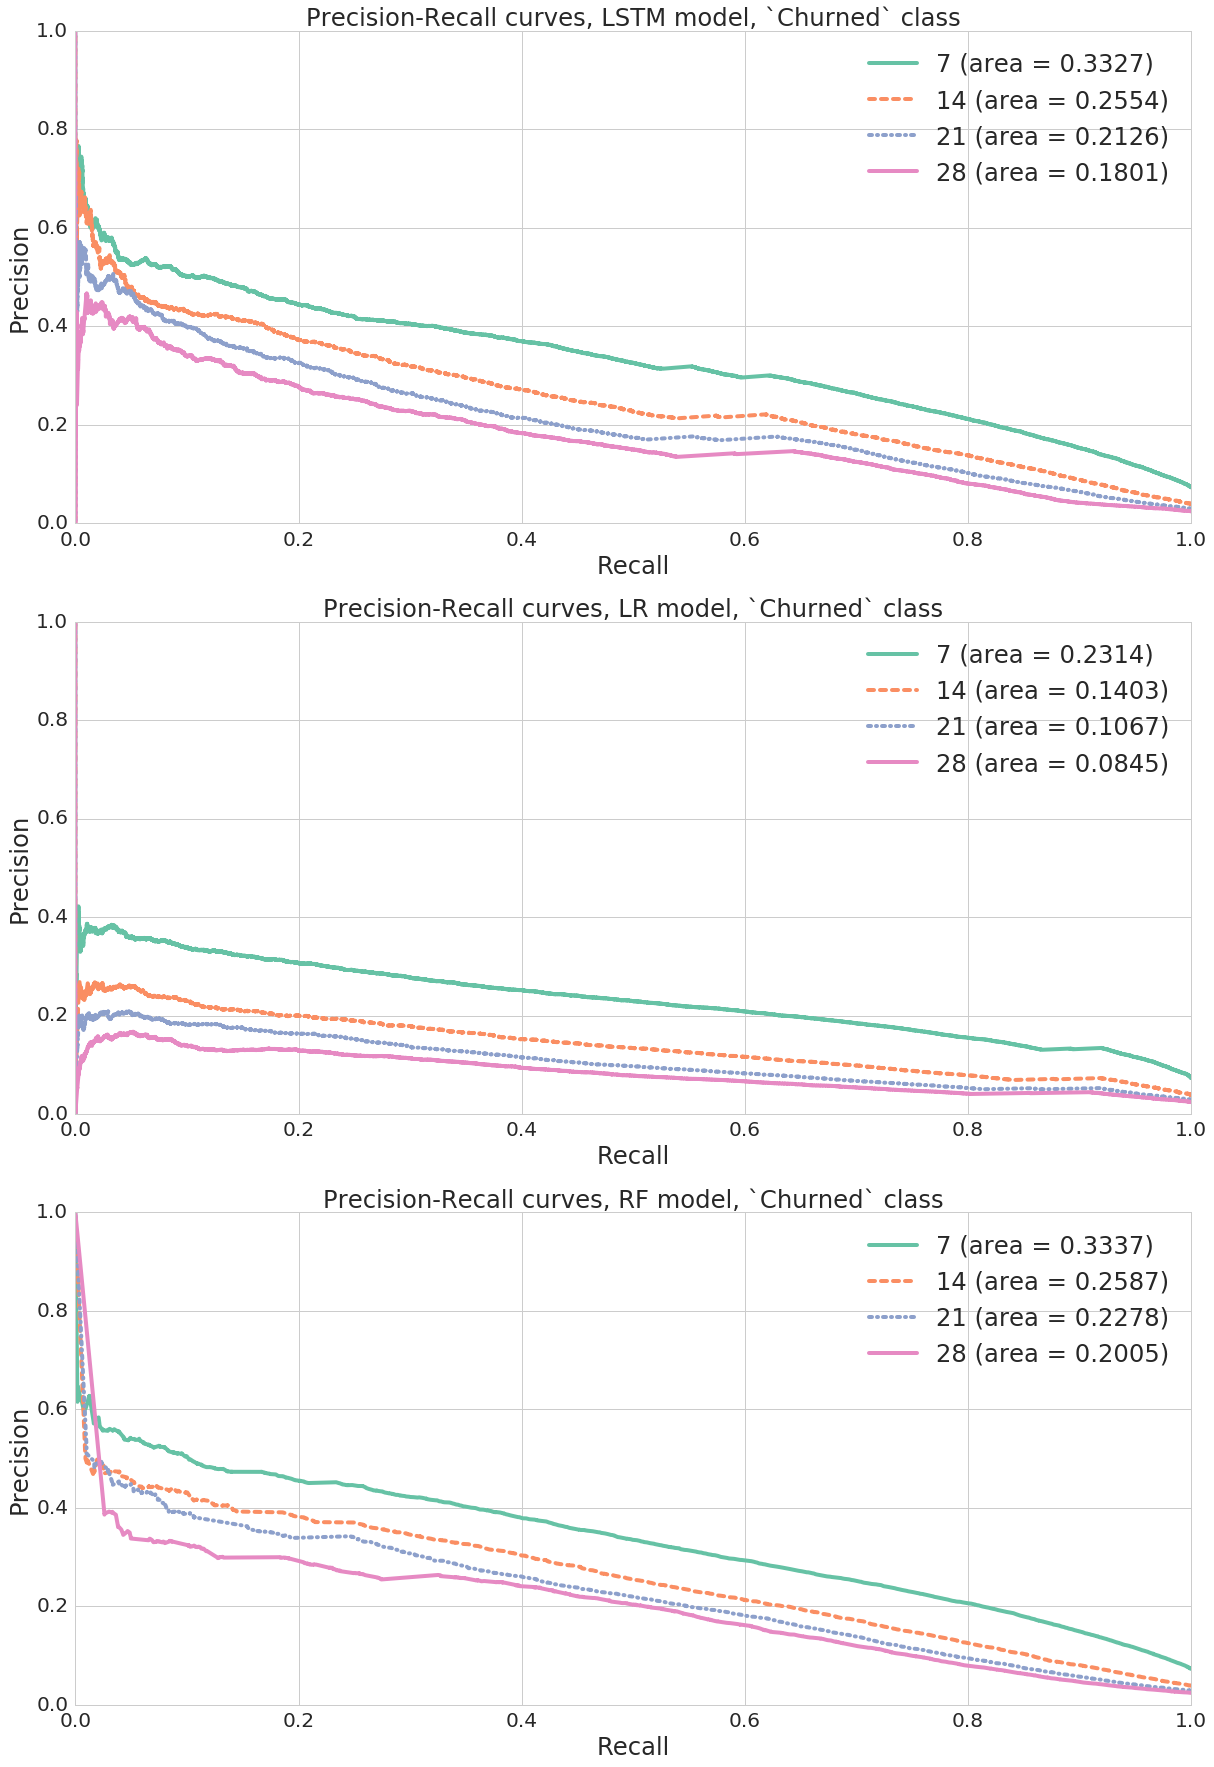

In [23]:
fig, axs = plt.subplots(nrows=3, figsize=(20,30))

for ax, model in zip(axs, models.keys()):
    metrics = models[model]
  
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('Recall', fontsize='xx-large')
    ax.set_ylabel('Precision', fontsize='xx-large')
    ax.set_title('Precision-Recall curves, {} model, `Churned` class'.format(model.upper()), fontsize='xx-large')

    linestyles = ['-', '--', '-.']*len(metrics['prec_recs'])
    for prec_rec, pr_auc, dsname, f1, ls in zip(metrics['prec_recs'], metrics['pr_aucs'], dsnames, metrics['f1s'], linestyles):
        prec = prec_rec[0]
        rec = prec_rec[1]
        ax.plot(rec, prec, linewidth=4.0, linestyle=ls, dash_capstyle='round', label='{0} (area = {1:.4f})'.format(dsname.split('_')[1][:-1], pr_auc))

    ax.tick_params(labelsize='x-large')
    ax.legend(fontsize='xx-large')

#plt.savefig('prc_pred_window.pdf', bbox_inches='tight')
#!gsutil cp 'prc_pred_window.pdf' 'gs://helder/churnr/plots/prc_pred_window.pdf'

### ROC Curves

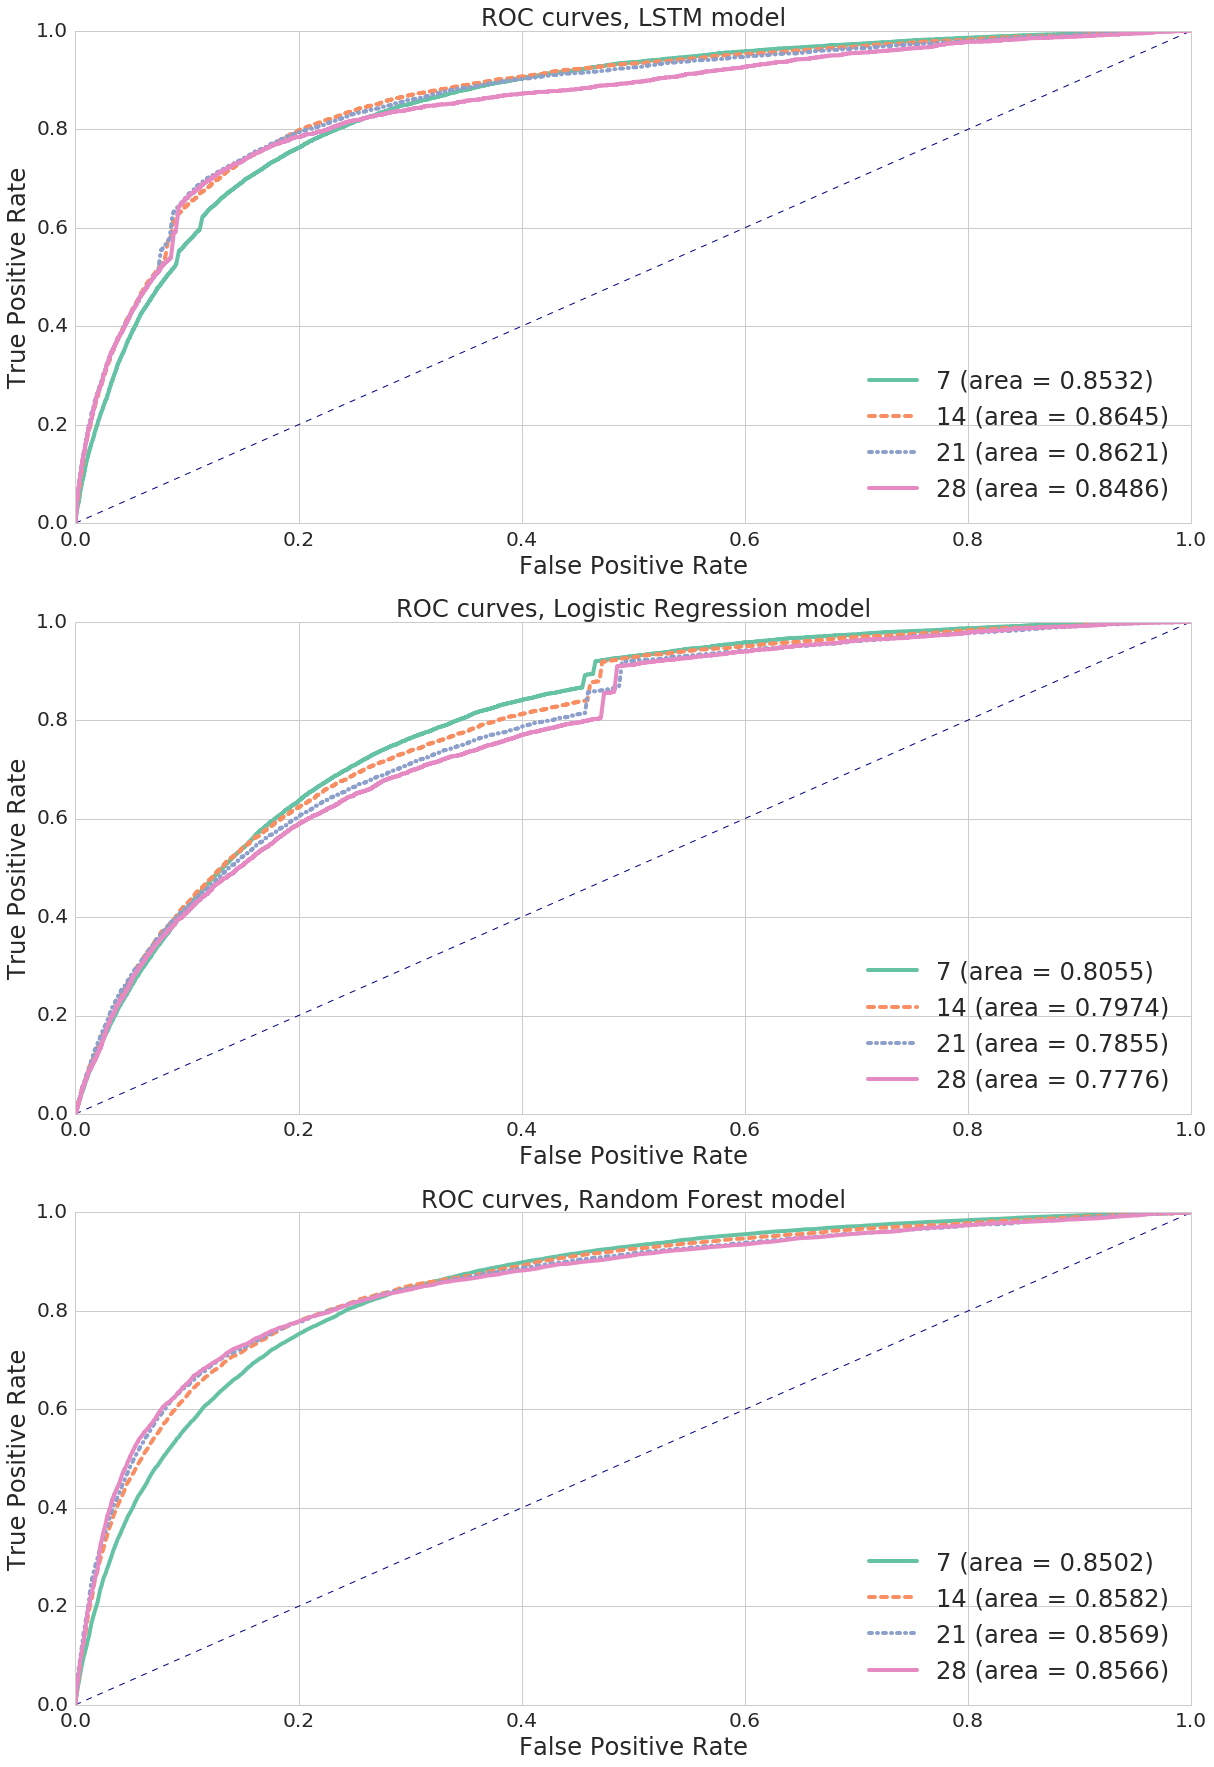

In [24]:
fig, axs = plt.subplots(nrows=3, figsize=(20,30))

for ax, model in zip(axs, models.keys()):
    metrics = models[model]

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate', fontsize='xx-large')
    ax.set_ylabel('True Positive Rate', fontsize='xx-large')
    ax.set_title('ROC curves, {} model'.format(models[model]['name']), fontsize='xx-large')

    linestyles = ['-', '--', '-.']*len(metrics['fpr_tprs'])
    for fpr_tpr, roc_auc, label, ls in zip(metrics['fpr_tprs'], metrics['roc_aucs'], dsnames, linestyles):
        fpr = fpr_tpr[0]
        tpr = fpr_tpr[1]
        ax.plot(fpr, tpr, linewidth=4.0, linestyle=ls, dash_capstyle='round', label='{0} (area = {1:.4f})'.format(label.split('_')[1][:-1], roc_auc))

    ax.legend(fontsize='xx-large', loc='best')
    ax.tick_params(labelsize='x-large')

#plt.savefig('roc_pred_window.pdf', bbox_inches='tight')
#!gsutil cp 'roc_pred_window.pdf' 'gs://helder/churnr/plots/roc_pred_window.pdf'

### Overall scores

In [25]:
dfs_models = []
for model, metrics in models.items():
  dfs = []
  for metric, dsname in zip(metrics['th_metrics'], dsnames):
    vals = {'Precision': metric[0], 'Recall': metric[1], 'F1-Score': metric[2], 'PR AUC': metric[3]}
    df = pd.DataFrame(vals, index=pd.Index(['Retained','Churned'], name='Label'))
    dfs.append(df)
  dfs = pd.concat(dfs, keys=[n.split('_')[1][:-1] for n in dsnames], names=['Days'])
  dfs_models.append(dfs)
dfs_models = pd.concat(dfs_models, keys=[n['name'] for n in models.values()], names=['Models'])
#print(dfs_models.to_latex(multirow=True))
dfs_models

F1-Score    PR AUC  Precision    Recall
Models              Days Label                                            
LSTM                7    Retained  0.865555  0.984565   0.979198  0.775547
                         Churned   0.339768  0.332712   0.216422  0.790036
                    14   Retained  0.903038  0.992245   0.988403  0.831247
                         Churned   0.255503  0.255430   0.153626  0.758490
                    21   Retained  0.905028  0.994108   0.991555  0.832390
                         Churned   0.204892  0.212596   0.118395  0.760491
                    28   Retained  0.919390  0.994288   0.992252  0.856497
                         Churned   0.193667  0.180108   0.111654  0.729512
Logistic Regression 7    Retained  0.819418  0.980245   0.973678  0.707353
                         Churned   0.275735  0.231385   0.168602  0.756309
                    14   Retained  0.823329  0.988834   0.984877  0.707310
                         Churned   0.162839  0.140317   0.091624  0.731049
                    21   Retained  0.821319  0.991033   0.987873  0.702825
                         Churned   0.120607  0.106731   0.065914  0.708495
                    28   Retained  0.816645  0.992240   0.989444  0.695228
                         Churned   0.099809  0.084522   0.053735  0.700000
Random Forest       7    Retained  0.859101  0.984071   0.979124  0.765291
                         Churned   0.331186  0.333677   0.209364  0.792058
                    14   Retained  0.889841  0.991600   0.988628  0.809004
                         Churned   0.236820  0.258722   0.139943  0.769557
                    21   Retained  0.898899  0.993507   0.991372  0.822205
                         Churned   0.195292  0.227806   0.112079  0.758240
                    28   Retained  0.907181  0.994554   0.992555  0.835330
                         Churned   0.177614  0.200510   0.100797  0.746585

### F1-scores for different prediction window sizes and models

(0.0, 0.4)

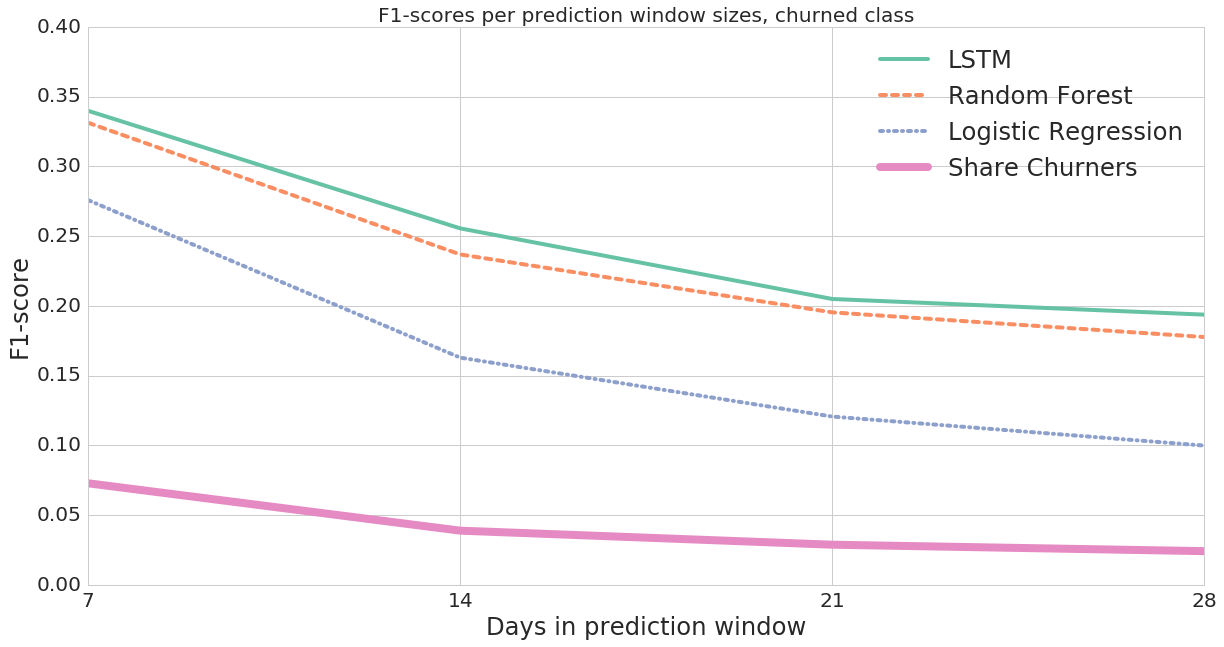

In [26]:
fig, ax = plt.subplots(nrows=1, figsize=(20,10))

ax.set_title('F1-scores per prediction window sizes, churned class')
ax.set_xlabel('Days in prediction window', fontsize='xx-large')
ax.set_ylabel('F1-score', fontsize='xx-large')

linestyles = ['-', '--', '-.']
for modeltype, ls in zip(['LSTM', 'Random Forest', 'Logistic Regression'], linestyles):
    vals = list(dfs_models.query("Label == 'Churned' and Models == '{}'".format(modeltype))['F1-Score'])
    x = list(range(len(vals)))
    ax.plot(x, vals, label=modeltype, linewidth=4.0, linestyle=ls, dash_capstyle='round')

ax.plot(x, class_dist, label='Share Churners', linewidth=8.0, linestyle='-', dash_capstyle='round')    
    
ax.legend(fontsize='xx-large', loc='best')
ax.tick_params(labelsize='x-large')
ax.xaxis.set_ticks([0.0, 1.0, 2.0, 3.0])
ax.set_xticklabels(['7', '14', '21', '28'])

ax.set_ylim(0.0, 0.4)

#plt.savefig('line_pred_window.pdf', bbox_inches='tight')
#!gsutil cp 'line_pred_window.pdf' 'gs://helder/churnr/plots/line_pred_window.pdf'

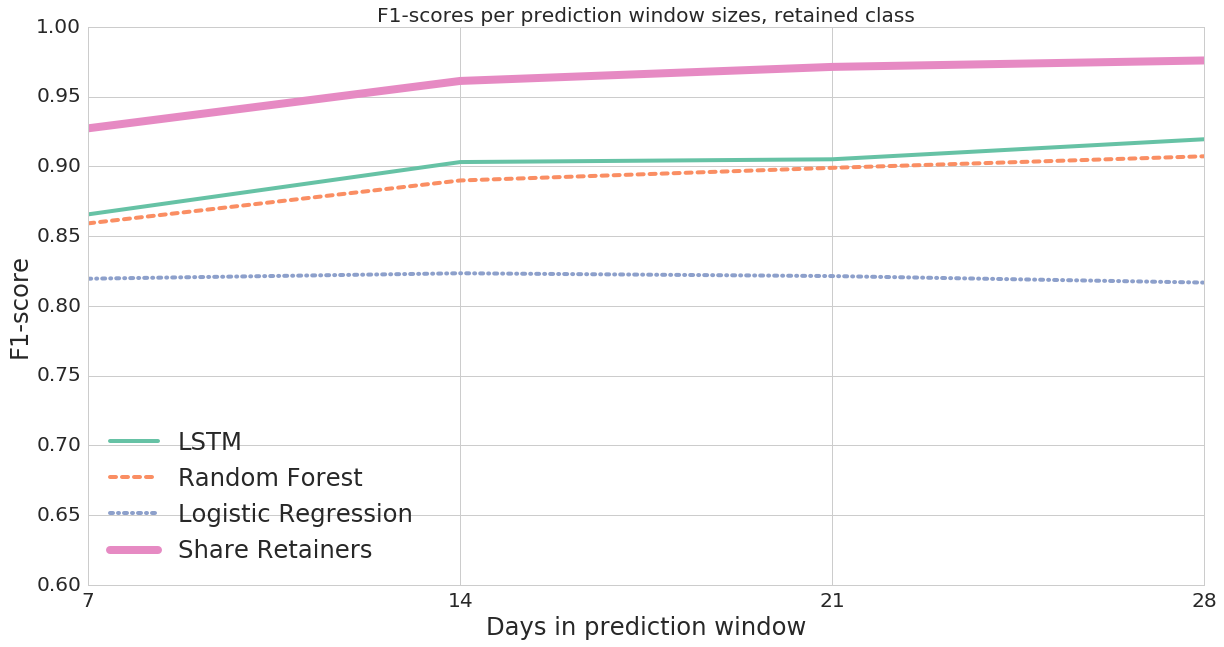

In [27]:
fig, ax = plt.subplots(nrows=1, figsize=(20,10))

#ax.set_xlim([0.0, float(len(modelnames))])
#plt.ylim([0.5, 1.0])

x = list(range(4))

ax.set_title('F1-scores per prediction window sizes, retained class')
ax.set_xlabel('Days in prediction window', fontsize='xx-large')
ax.set_ylabel('F1-score', fontsize='xx-large')

linestyles = ['-', '--', '-.']
for modeltype, ls in zip(['LSTM', 'Random Forest', 'Logistic Regression'], linestyles):
    vals = list(dfs_models.query("Label == 'Retained' and Models == '{}'".format(modeltype))['F1-Score'])
    ax.plot(x, vals, label=modeltype, linewidth=4.0, linestyle=ls, dash_capstyle='round')

ax.plot(x, 1.0-np.array(class_dist), label='Share Retainers', linewidth=8.0, linestyle='-', dash_capstyle='round')     
    
ax.legend(fontsize='xx-large', loc='best')
ax.tick_params(labelsize='x-large')

ax.set_ylim(0.6,1.0)

ax.xaxis.set_ticks([0.0, 1.0, 2.0, 3.0])
ax.set_xticklabels(['7', '14', '21', '28'])

#plt.savefig('line_pred_window_retained.pdf', bbox_inches='tight')
#!gsutil cp 'line_pred_window_retained.pdf' 'gs://helder/churnr/plots/line_pred_window_retained.pdf'